# <font color='darkblue'>Deep Neural Network for Image Classification</font>

## <font color='indianred'>Packages</font>

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- `dnn_app_utils` provides the functions implemented previosuly.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
np.random.seed(1)

## <font color='indianred'>Dataset</font>

You will use the same `Cat/non-Cat` dataset as in `Logistic Regression as a Neural Network`

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
print('X shape : ' + str(train_x_orig.shape))
print('Y shape : ' + str(train_y.shape))

X shape : (209, 64, 64, 3)
Y shape : (1, 209)


y = 0 -----> non-cat


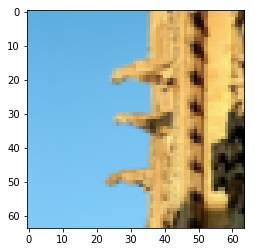

In [3]:
# Example of a picture
index = np.random.randint(low=0, high=209)
plt.imshow(train_x_orig[index, :])
print ("y = " + str(train_y[0,index]) + " -----> " + classes[train_y[0,index]].decode("utf-8"))

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
m_test  = test_x_orig.shape[0]

print ("Number of training examples:  " + str(m_train))
print ("Number of testing examples :  " + str(m_test))
print ("train_x_orig shape         :  " + str(train_x_orig.shape))
print ("train_y shape              :  " + str(train_y.shape))
print ("test_x_orig shape          :  " + str(test_x_orig.shape))
print ("test_y shape               :  " + str(test_y.shape))

Number of training examples:  209
Number of testing examples :  50
train_x_orig shape         :  (209, 64, 64, 3)
train_y shape              :  (1, 209)
test_x_orig shape          :  (50, 64, 64, 3)
test_y shape               :  (1, 50)


In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   #"-1" makes reshape flatten remaining dims
test_x_flatten  = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x shape: " + str(train_x.shape))
print ("test_x shape : " + str(test_x.shape))


train_x shape: (12288, 209)
test_x shape : (12288, 50)


## <font color='indianred'>Architecture of your model</font>

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

### <font color='mediumseagreen'>2-layer neural network</font>

<br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT. </center>

<b>Detailed Architecture</b>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take ReLU to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, take the sigmoid of the result. If it is greater than 0.5, you classify it to be a 1; else 0

### <font color='mediumseagreen'>L-layer deep neural network</font>

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID

<b>Detailed Architecture</b>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the ReLU of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it as $1$.

## <font color='indianred'>Two-layer neural network</font>

Use the helper functions in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:

```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation_func):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation_func):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
# CONSTANTS
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 1000, 
                    print_cost=True, checkpoint = 200):
    
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    ----------
    X              -- input data, of shape (n_x, number of examples)
    Y              -- true "label" vector (containing 1 or 0, of shape (1, number of examples)
    layers_dims    -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate  -- learning rate of the gradient descent update rule
    print_cost     -- If set to True, this will print the cost 
    
    Returns:
    --------
    parameters     -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                          # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary,
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. 
        # Inputs: "X, W1, b1, W2, b2". 
        # Output: "A1, cache1, A2, cache2".
        
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. 
        # Inputs: "dA2, cache2, cache1". 
        # Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
    
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
    

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost
        if print_cost and i % checkpoint == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % checkpoint == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6930497356599888
Cost after iteration 200: 0.6325140647912677
Cost after iteration 400: 0.5601966311605747
Cost after iteration 600: 0.4754901313943325
Cost after iteration 800: 0.4007977536203887


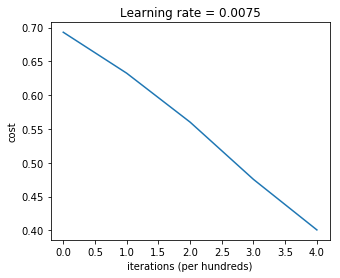

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), 
                             num_iterations = 801, print_cost=True, checkpoint = 200)

In [9]:
predictions_train =  predict(train_x, train_y, parameters)
predictions_test  =  predict(test_x, test_y, parameters)

Accuracy: 0.870813397129
Accuracy: 0.78


Cost after iteration 0: 0.6930497356599888
Cost after iteration 2000: 0.07439078704319081
Cost after iteration 4000: 0.013498961092799472


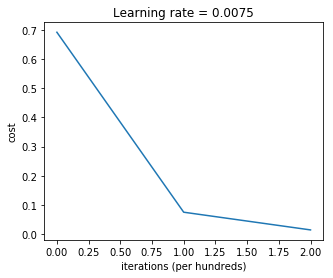

In [10]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), 
                             num_iterations = 5001, print_cost=True, checkpoint = 2000)

In [11]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test =  predict(test_x, test_y, parameters)

Accuracy: 1.0
Accuracy: 0.7


**Note**

You may notice that running the model on fewer iterations gives better accuracy on the test set. This is called `Early stopping`. It is a way to prevent overfitting.

## <font color='IndianRed'>L-layer Neural Network</font>

Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need are:

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [12]:
### Layers ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [13]:
#L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, 
                  print_cost=False, checkpoint = 500):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X         -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y         -- true "label" vector of shape (1, number of examples)
    layers_dims     -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate   -- learning rate of the gradient descent update rule
    num_iterations  -- number of iterations of the optimization loop
    print_cost      -- if True, it prints the cost
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        if print_cost and i % checkpoint == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 500: 0.540138
Cost after iteration 1000: 0.315187
Cost after iteration 1500: 0.161189
Cost after iteration 2000: 0.113821


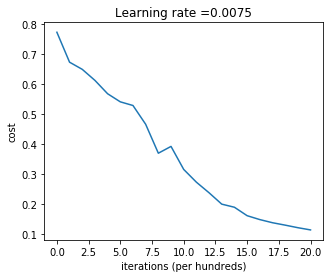

In [14]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2001, 
                           print_cost = True, checkpoint = 500)

In [15]:
pred_train = predict(train_x, train_y, parameters)
pred_test  =  predict(test_x, test_y, parameters)

Accuracy: 0.980861244019
Accuracy: 0.8


## <font color='Blue'>Analysis</font>

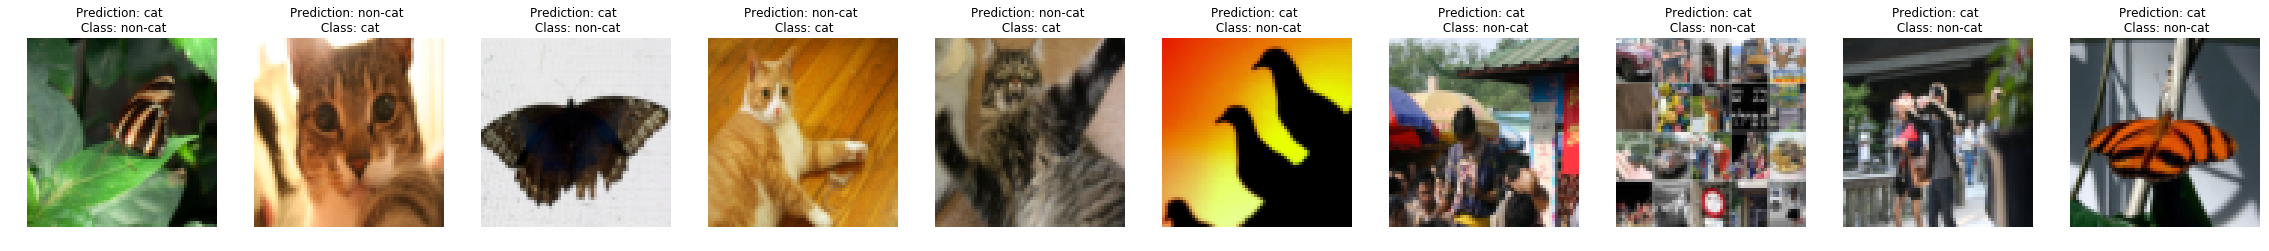

In [16]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

## <font color = 'Blue'>Test</font>

Accuracy: 1.0
1.0,cat


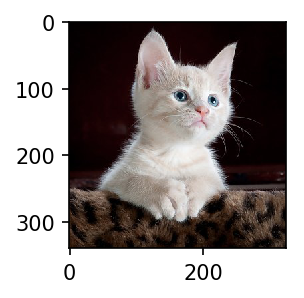

In [17]:
my_image = "cat.jpg" # change this to the name of your image file 
my_label_y = [1]     # the true class of your image (1 -> cat, 0 -> non-cat)
num_px = 64

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

from matplotlib.pyplot import figure
figure(num=None, figsize=(2, 2), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(image)
print (str(np.squeeze(my_predicted_image)) + "," + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8"))

Accuracy: 1.0
0.0,non-cat


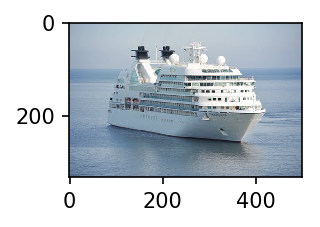

In [18]:
my_image_2 = "ship.jpeg"
my_label_y = [0]
num_px = 64
fname = "images/" + my_image_2
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

from matplotlib.pyplot import figure
figure(num=None, figsize=(2, 2), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(image)
print (str(np.squeeze(my_predicted_image)) + "," + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8"))